<a href="https://colab.research.google.com/github/ochoa-josue/techwise-deepfake-classification/blob/feature%2Fgan-model/gan_discriminator_deepfake_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet tensorflow matplotlib tensorflow-datasets ipywidgets

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory #load image datasets
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, load_model #sequential api for generator and discriminator
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import AUC #area under the curve for model performance (especially imbalanced datasets)
import numpy as np

In [3]:
print(tf.__version__)

2.12.0


### **Retrieve and Preprocess Dataset**

In [4]:
from google.colab import drive
import os
import zipfile
import re


if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
# os.chdir("/content/drive/My Drive/conforming-images-subset") #change current working directory to specified directory

zip_file_path = '/content/drive/My Drive/conforming_images_subset.zip'
extracted_dir_path = '/content/conforming-images-subset/'
os.makedirs(extracted_dir_path, exist_ok=True) #creates dir if non-existent

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extracted_dir_path)

extracted_files = os.listdir(extracted_dir_path)
print(f"extracted files: {extracted_files}")
print(extracted_files)

Mounted at /content/drive
extracted files: ['test', 'train', 'valid']
['test', 'train', 'valid']


In [6]:
# train_dir = "/content/drive/My Drive/conforming-images-subset/train"
# valid_dir = "/content/drive/My Drive/conforming-images-subset/valid"
# test_dir = "/content/drive/My Drive/conforming-images-subset/test"

train_dir = os.path.join(extracted_dir_path, 'train')
valid_dir = os.path.join(extracted_dir_path, 'valid')
test_dir = os.path.join(extracted_dir_path, 'test')

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.05),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.05, width_factor=0.05),
])

def preprocess(images, labels):
  images = tf.cast(images, tf.float32) #convert tensor img to tf.float32 type
  images = images / 255.0 #normalize data between 0 to 1

  return images, labels

def preprocess_with_augmentation(images, labels):
  images = data_augmentation(images, training=True)
  images = tf.cast(images, tf.float32) #convert tensor img to tf.float32 type
  images = images / 255.0 #normalize data between range 0 to 1
  return images, labels


In [8]:
train_dataset = image_dataset_from_directory(train_dir, label_mode='binary', image_size=(256,256), batch_size=32) #image anomaly detection
valid_dataset = image_dataset_from_directory(valid_dir, label_mode='binary', image_size=(256,256), batch_size=32)
test_dataset = image_dataset_from_directory(test_dir, label_mode='binary', image_size=(256,256), batch_size=32)

Found 20000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


In [9]:
train_dataset = train_dataset.map(preprocess_with_augmentation)
valid_dataset = valid_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

### **Build GAN**

In [10]:
class GAN(tf.keras.Model):
  def __init__(self, generator, discriminator):
    super(GAN, self).__init__() #invoking constructor of tf.keras.Model to initialize GAN proxy object
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_optimizer, d_optimizer, loss_function):
    super(GAN, self).compile() #ensure compilation of parent class is executed
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer
    self.loss_function = loss_function

  def train_step(self, real_images): #override parent train_step when calling to TensorFlow fit function
    batch_size = tf.shape(real_images)[0] #retrieving batch size
    noise_dim = 128 #128 dimensions

    #generate fake images
    random_noise = tf.random.normal(shape=(batch_size, noise_dim)) #create random noise vectors with Gaussian distribution
    fake_images = self.generator(random_noise, training=True)

    #train discriminator
    with tf.GradientTape() as disc_tape: #records operations on tensors; thereafter performs automatic differentiation, in other words, compute derivatives or gradients of functions
        real_output = self.discriminator(real_images, training=True)
        fake_output = self.discriminator(fake_images, training=True)

        #calculate loss
        real_loss = self.loss_function(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_function(tf.zeros_like(fake_output), fake_output)

        #total discriminator loss
        disc_loss = real_loss + fake_loss

    #calculate gradients for discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

    #apply gradients to the optimizer
    self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    #train generator
    with tf.GradientTape() as gen_tape:
      fake_images = self.generator(random_noise, training=True) #generate fake images
      fake_output = self.discriminator(fake_images, training=True) #disc predict fake images
      gen_loss = self.loss_function(tf.ones_like(fake_output), fake_output) #show generator loss; maximimize loss to optimize generator

    #calculate gradients for generator
    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    #apply gradients to the optimizer
    self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    return {'disc_loss': disc_loss, 'gen_loss': gen_loss}


In [11]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128)) #intakes 128-dimesional input of random noise to output tensor shape
  model.add(LeakyReLU(0.2)) #introduce non-linearlity for continued learning
  model.add(BatchNormalization(momentum=0.8)) #stabilize training process by tracking moving averages overtime; faster convergence
  model.add(Reshape((7, 7, 128))) #reshapes into 4D tensor which inclues batch size, height, width, and channels

  #upsampling block 1
  model.add(UpSampling2D()) #double dimensions of the input tensor for higher resolutions from low-dimensional noise vectors
  model.add(Conv2D(128, 5, padding='same')) #adds a convolutional layer with 256 filters, 5x5 kernel size, and same padding to preserve spatial dimensions as input image
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  #upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(64, 5, padding='same')) #reduce filters to prevent overfitting and allow feature abstraction e.g. capturing simple patterns (edges, textures)
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  #simplify model
  #convolution block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  #output layer adjustment; output layer is tanh activation
  model.add(Conv2D(3, 4, padding='same', activation='sigmoid')) #sigmoid activation for data normalized between 0 and 1 for RGB images

  return model

In [12]:
def build_discriminator(input_shape=(256, 256, 3)):
  model = Sequential([
      #convolution block 1
      Conv2D(32, kernel_size=5, strides=2, input_shape=input_shape, padding="same", kernel_regularizer=l2(0.01)), #stride reduces spatial dimensions by half
      LeakyReLU(alpha=0.2),
      Dropout(0.3), #prevent overfitting where 30% of input units or features are randomly set to zero

      #convolution block 2
      Conv2D(64, kernel_size=5, strides=2, padding="same", kernel_regularizer=l2(0.01)),
      LeakyReLU(alpha=0.2),
      Dropout(0.3),

      #simplify model
      #convolution block 3
      Conv2D(256, kernel_size=5, strides=2, padding="same"),
      LeakyReLU(alpha=0.2),
      Dropout(0.3),

      #flatten and output layer
      Flatten(), #flatten into a 1D tensor for easier integration with fully connected layers
      Dense(1, kernel_regularizer=l2(0.01)) #indicate whether image is real or fake
  ])

  return model

### **Data Visualization and Compiling GAN Model**

In [13]:
# generator = build_generator()
# g_optimizer = tf.keras.optimizers.Adam(1e-4) #find best convergence along with optimal learning rate
# noise_dim = 128
# gan_model = GAN(generator, discriminator, noise_dim) #create GAN
# gan_model.compile(g_optimizer=g_optimizer, d_optimizer=d_optimizer) #compile GAN
# gan_model.fit(train_dataset, epochs=50, validation_data=valid_dataset, callbacks=[checkpoint_cb, early_stopping_cb])

discriminator = build_discriminator()
d_optimizer = tf.keras.optimizers.Adam(1e-4)
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
discriminator.compile(optimizer=d_optimizer, loss=loss_function, metrics=['accuracy', AUC(name='auc')])

In [13]:
# def check_and_remount_drive():
#   drive_mount_point = '/content/drive'
#   drive_base_path = '/content/drive/My Drive'

#   if not os.path.isdir(drive_base_path): #look for base path to ensure drive mounted
#     print('Mounting Google Drive')
#     drive.mount(drive_mount_point, force_remount=True)
#     print("Mounted Google Drive successfully")

In [14]:
import logging
from google.colab import output
import time
import json

model_dir = '/content/drive/My Drive/models'
log_dir = '/content/drive/My Drive/logs'
state_file = os.path.join(model_dir, 'training_state.json')

#if dir non-existent
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

current_time = time.strftime("%Y%m%d-%H%M%S")
log_file_path = os.path.join(log_dir, f"training_{current_time}.log.txt")
logging.basicConfig(filename=log_file_path, level=logging.INFO, format='%(asctime)s %(message)s')

In [15]:
checkpoint_cb = ModelCheckpoint(os.path.join(model_dir, "ckpt_epoch_{epoch:02d}.h5"), save_freq='epoch', verbose=1) #display progress bar during saving
# checkpoint_cb = ModelCheckpoint("/content/drive/My Drive/models/best_discriminator.h5", save_best_only=True, monitor='val_loss') #callback to save the best model checkpoint during training
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss') #stop training if no improvement at 15 consecutive epochs
# tensorboard_cb = TensorBoard(log_dir='/content/drive/My Drive/logs', histogram_freq=1) #TensorBoard callback to visualize model performance
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
def save_training_state(epoch, accuracy):
  state = {'last_epoch': epoch, 'last_accuracy': accuracy}
  with open(state_file, 'w') as f:
    json.dump(state, f) #serialize Python objects into JSON formatted str

def load_training_state():
  if os.path.exists(state_file):
    print(f"Found training state file: {state_file}")
    with open(state_file) as f:
      return json.load(f)
  else:
    print(f"No training state file found at {state_file}. Creating a new one.")
    save_training_state(0, 0.0)
    return {'last_epoch': 0, 'last_accuracy': 0}

class SaveStateCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    save_training_state(epoch + 1, logs.get('accuracy', 0.0))

state = load_training_state()

Found training state file: /content/drive/My Drive/models/training_state.json


In [20]:
checkpoint_files = [f for f in os.listdir(model_dir) if 'ckpt_epoch_' in f and f.endswith('.h5')] #find latest checkpoint file
latest_epoch = state['last_epoch']
latest_accuracy = state['last_accuracy']

if checkpoint_files: #find max checkpoint
    epochs = [int(re.search(r'ckpt_epoch_(\d+).h5', f).group(1)) for f in checkpoint_files]
    latest_epoch = max(epochs)
    latest_checkpoint = f'ckpt_epoch_{latest_epoch}.h5'
    checkpoint_path = os.path.join(model_dir, latest_checkpoint)

    print(f"Loading weights from {checkpoint_path}")
    discriminator.load_weights(checkpoint_path)
    print(f"Resuming training from epoch {latest_epoch + 1} with last accuracy {latest_accuracy}")
else:
    print("No checkpoint files found. Starting or continuing from the last known state.")

initial_epoch = latest_epoch
total_epochs = 100

save_state_cb = SaveStateCallback()

history = discriminator.fit(train_dataset, epochs=total_epochs, validation_data=valid_dataset,
                  callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb, save_state_cb],
                  initial_epoch=initial_epoch)

KeyError: 'last_epoch'

In [19]:
discriminator.save('/content/drive/My Drive/final_discriminator_model.h5')

In [21]:
test_result = discriminator.evaluate(test_dataset) #evaluate model performance for unseen data

125/125 [==============================] - 144s 1s/step - loss: 1.1977 - accuracy: 0.5082 - auc: 0.5021


In [22]:
if len(test_result) >= 2:
    test_loss = test_result[0]
    test_accuracy = test_result[1]
    print(f"test accuracy: {test_accuracy*100:.2f}%")
    print(f"test loss: {test_loss*100:.2f}%")

test accuracy: 50.82%
test loss: 119.77%


In [37]:
file_path = '/content/drive/My Drive/models/training_state.json'

with open(file_path, 'r') as file:
    history = json.load(file)

In [45]:
auc_values = [epoch['auc'] for epoch in history['epoch_data']]
val_auc_values = [epoch['val_auc'] for epoch in history['epoch_data']]
loss_values = [epoch['loss'] for epoch in history['epoch_data']]
val_loss_values = [epoch['val_loss'] for epoch in history['epoch_data']]
accuracy_values = [epoch['accuracy'] for epoch in history['epoch_data']]
val_accuracy_values = [epoch['val_accuracy'] for epoch in history['epoch_data']]
epochs = range(22, 22 + len(auc_values))

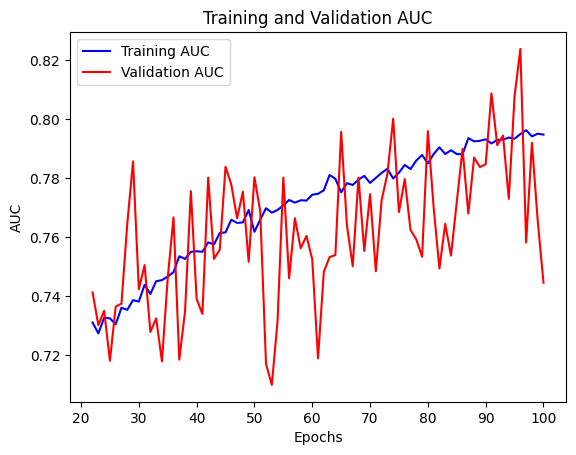

In [42]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

#visualize AUC
plt.plot(epochs, auc_values, label='Training AUC', color='b')
plt.plot(epochs, val_auc_values, label='Validation AUC', color='r')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

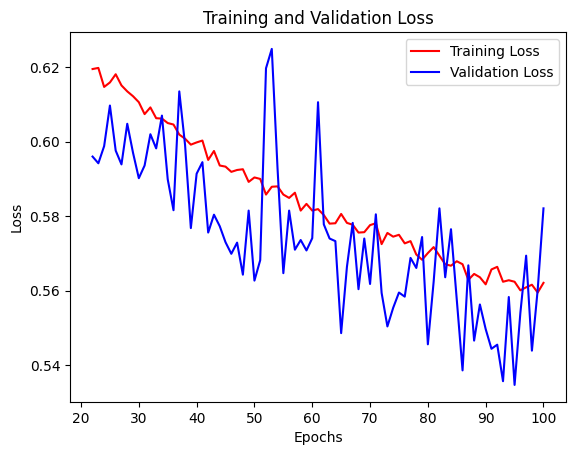

In [43]:
plt.plot(epochs, loss_values, label='Training Loss', color='r')
plt.plot(epochs, val_loss_values, label='Validation Loss', color='b')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

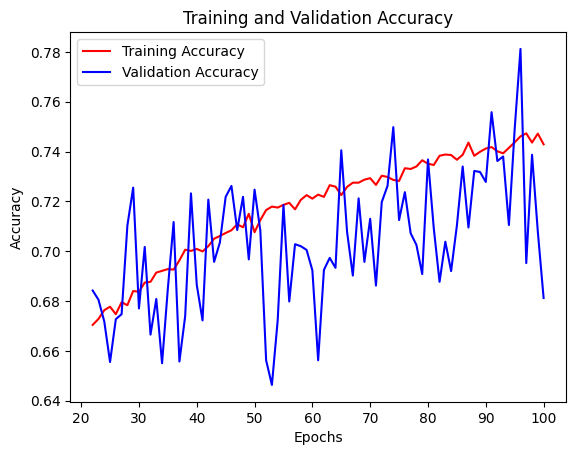

In [46]:
plt.plot(epochs, accuracy_values, label='Training Accuracy', color='r')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy', color='b')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def get_predictions_and_labels(model, dataset):
  predictions = []
  true_labels = []

  for images, labels in dataset:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(np.int) #convert probabilities to binary labels
    predictions.extend(preds.flatten())
    true_labels.extend(labels.numpy().flatten())

  return np.array(predictions), np.array(true_labels)

In [ ]:
predictions, true_labels = get_predictions_and_labels(discriminator, valid_dataset)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

In [ ]:
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_deepfake(image_path, model):
  img = image.load_img(image_path, target_size=(256, 256))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0) #expand dimensions
  img_array = img_array / 255.0 #normalize from 0 to 1
  logits = model.predict(img_array)
  probabilities = tf.sigmoid(logits) #convert logits to probabilities

  return "fake" if probabilities.numpy()[0] < 0.5 else "real"

In [ ]:
saved_discriminator = load_model('final_discriminator_model.h5')

# example usage
# result = predict_deepfake('image_path.jpg', saved_discriminator)
# print("The image is: ", result)